**The Game Sequence**

The player is numbered from 1, 2, ... the global variables *cards_on_board* and *the_cards* are what you get in the box when you buy Sequence. That is the board and cards. Also you will get discs in your player's colour.

This notebook contains the following functions:

  1. **initGame**(): returns the initial *discs_on_board* and deals out cards to the players stored in the list of lists called *hand*.
  2. **isTerminal**(discs_on_board, player): determines if the lookahead of *player* is terminal, if so this *player* wins
  3. **getMoves**(discs_on_board, hand, player) will return a list of tuples ($i,j$) for cards in hand, for normal cards (*legal_moves*) one eyed jacks (*legal_moves_1J*) and two eyed jacks (*legal_moves_2J*)
  4. **drawCard**(deck, hand, card_played) will return a new *hand[player-1]* for *player* and updated the deck by removing the top card. The *card_played* by the *player* is removed from its hand.
  5. **pretty_print**()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from SequenceGame import SequenceEnv

In [2]:
env = SequenceEnv()

set()


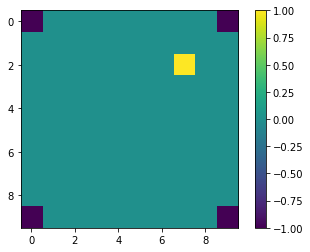

set()


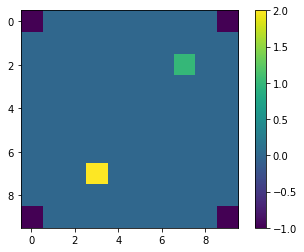

set()


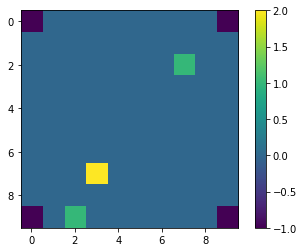

set()


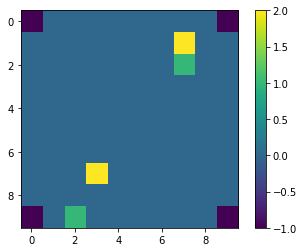

set()


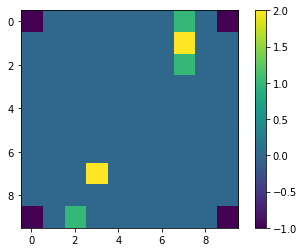

set()


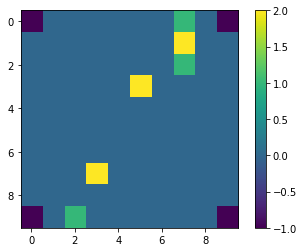

set()


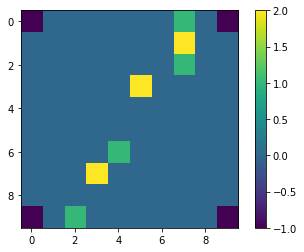

set()


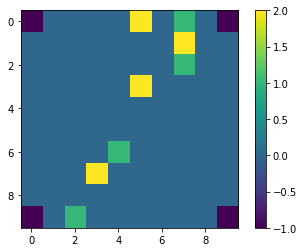

set()


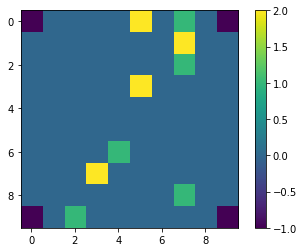

set()


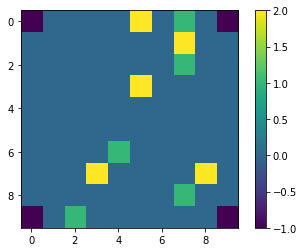

set()


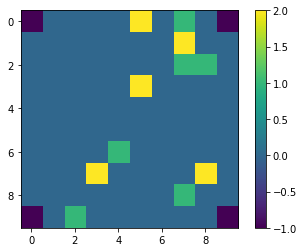

set()


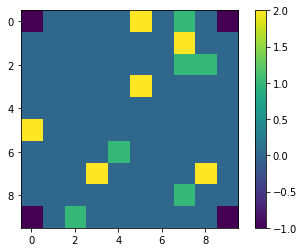

set()


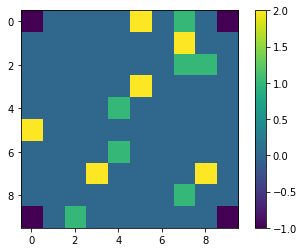

set()


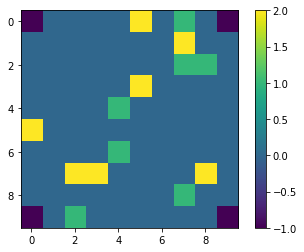

set()


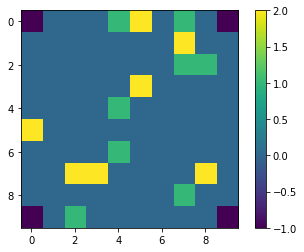

set()


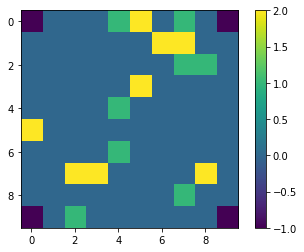

set()


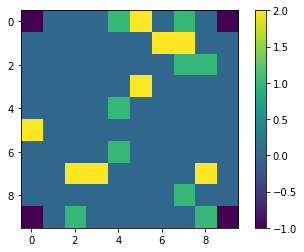

set()


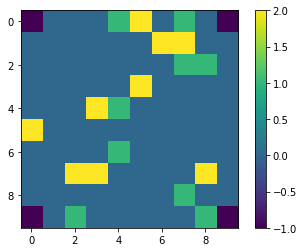

set()


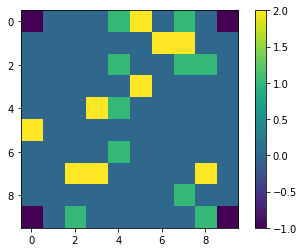

set()


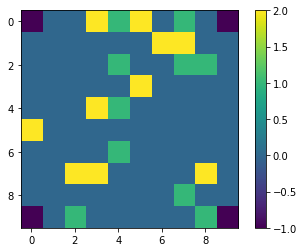

set()


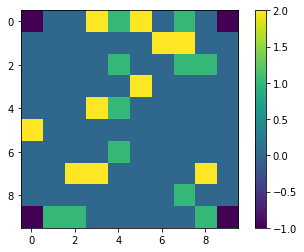

set()


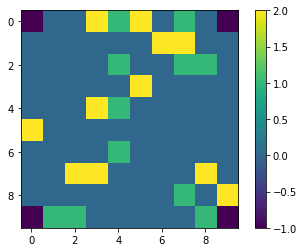

set()


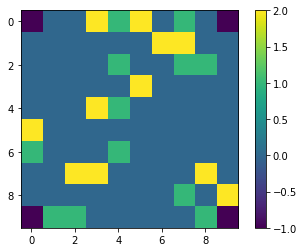

set()


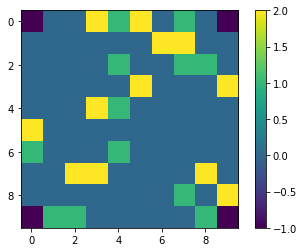

set()


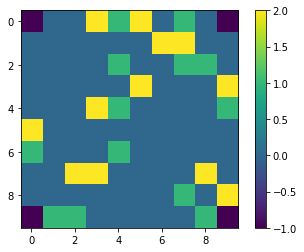

set()


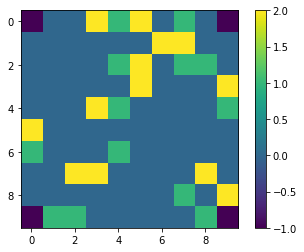

set()


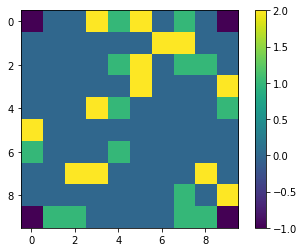

set()


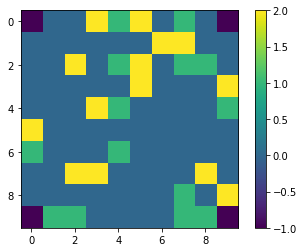

set()


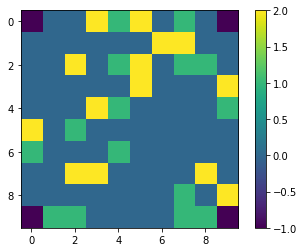

set()


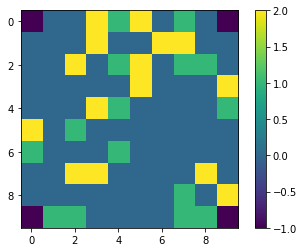

set()


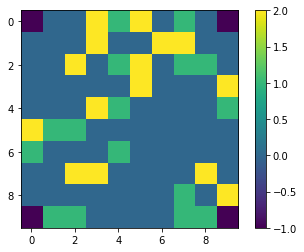

set()


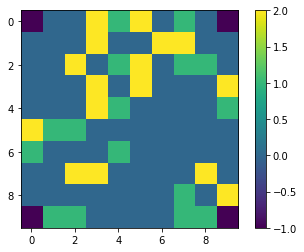

set()


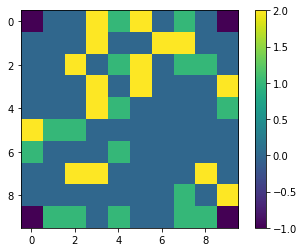

set()


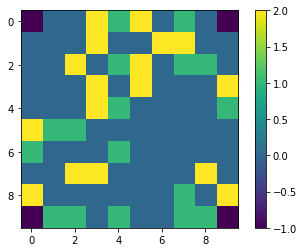

set()


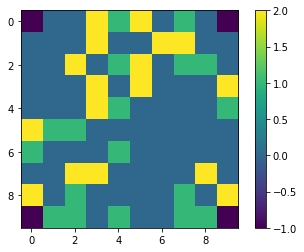

set()


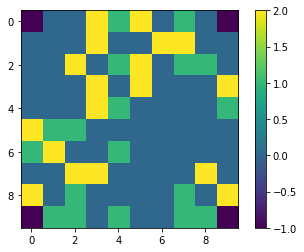

set()


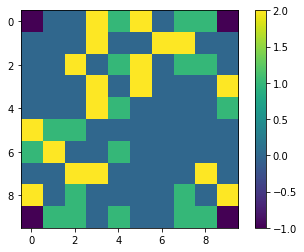

set()


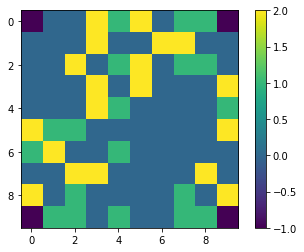

set()


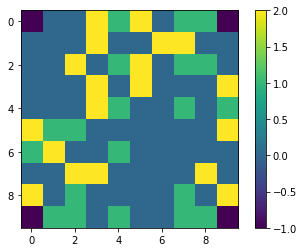

set()


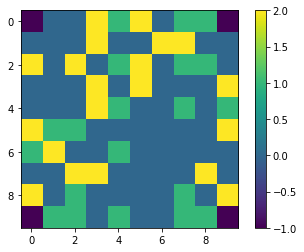

set()


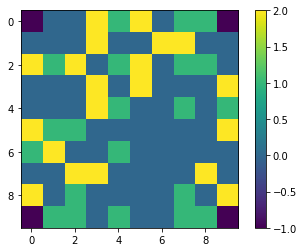

set()


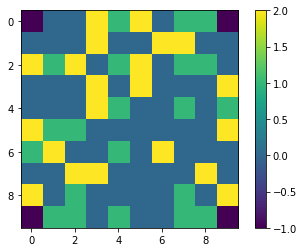

set()


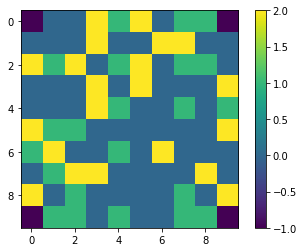

set()


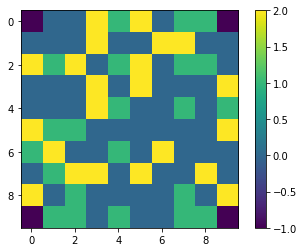

set()


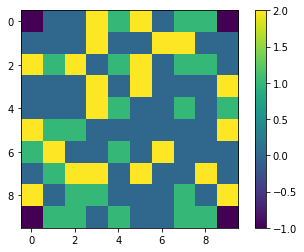

set()


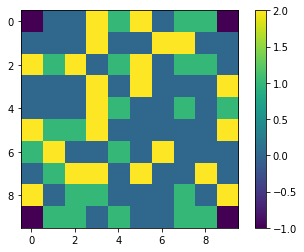

set()


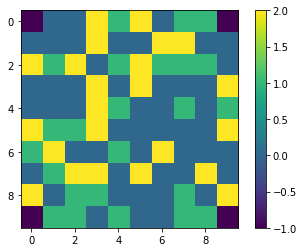

set()


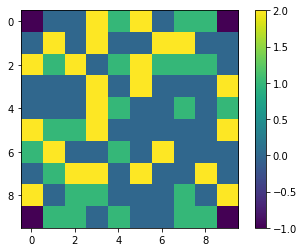

set()


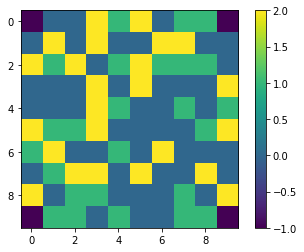

set()


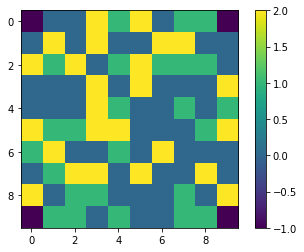

set()


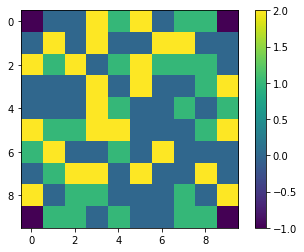

set()


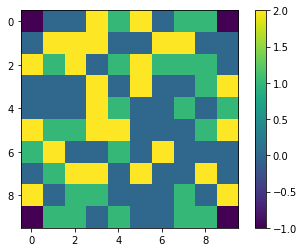

set()


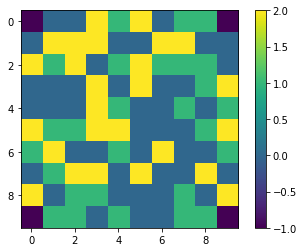

set()


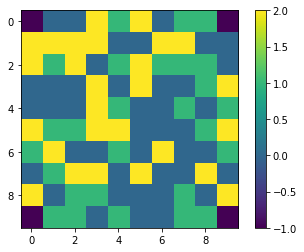

set()


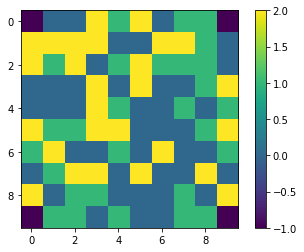

set()


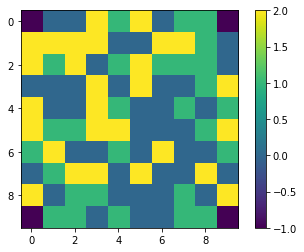

set()


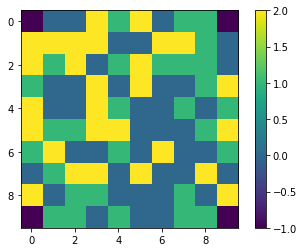

set()


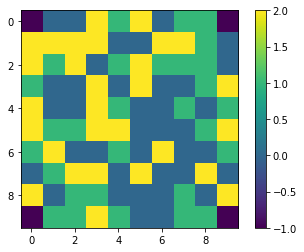

set()


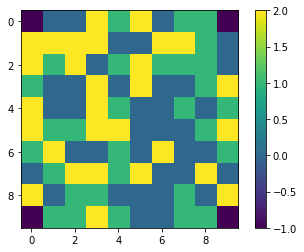

set()


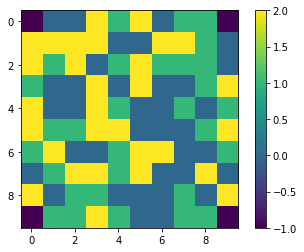

set()


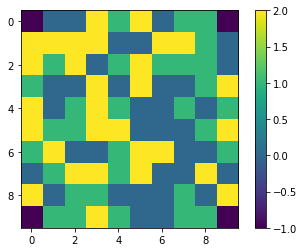

set()


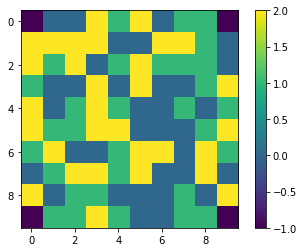

set()


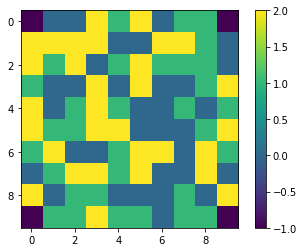

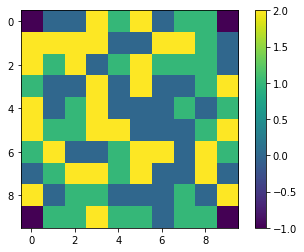

set()


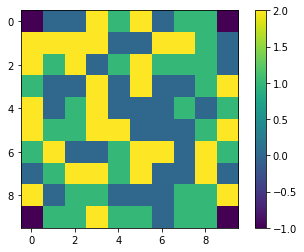

set()


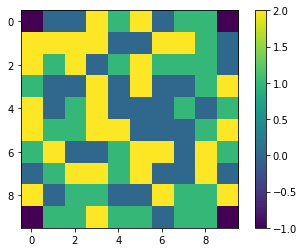

set()


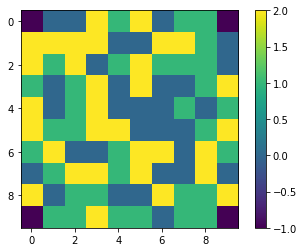

set()


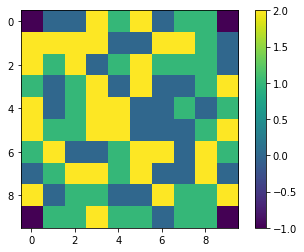

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


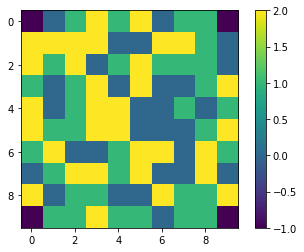

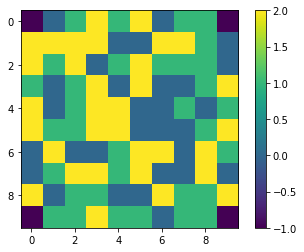

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


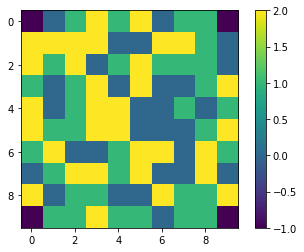

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


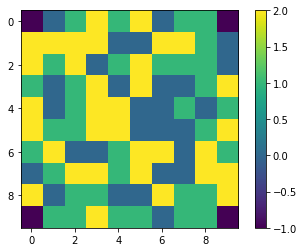

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


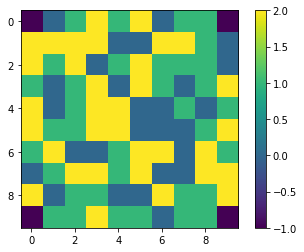

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


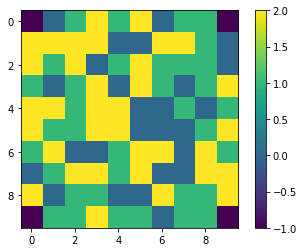

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


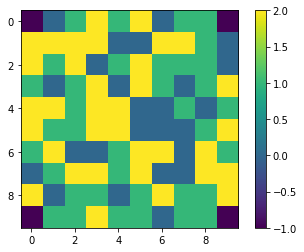

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


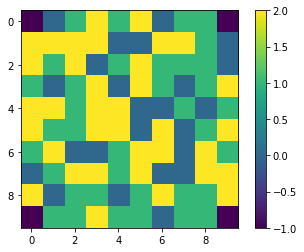

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


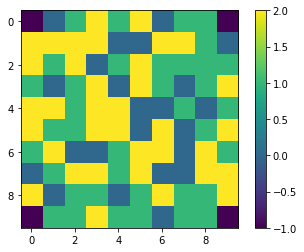

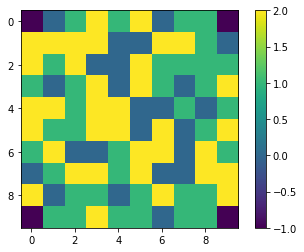

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


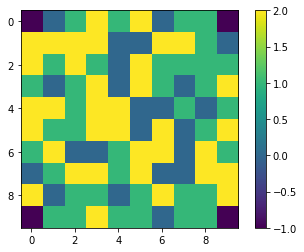

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


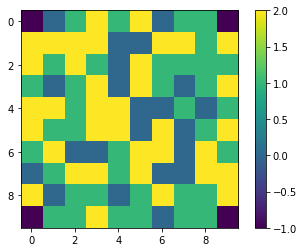

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


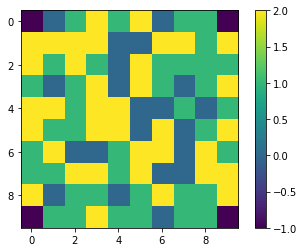

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


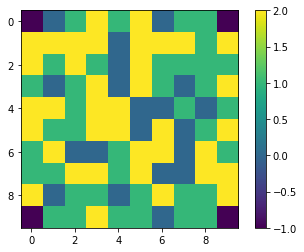

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


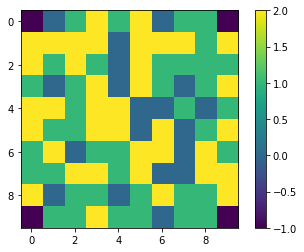

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}


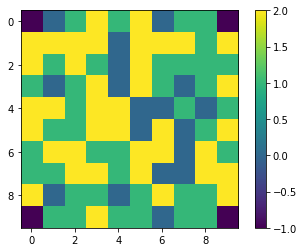

{(4, 4), (0, 0), (1, 1), (3, 3), (2, 2)}
no_feasible_move = 0  player = 1  cards in deck = 5  last played card at coords: ( 9 6 ) sequences: [2, 1] sequence discs: {(4, 4), (7, 4), (0, 0), (9, 9), (1, 1), (9, 6), (9, 5), (5, 2), (3, 3), (9, 8), (2, 2), (6, 3), (9, 7), (8, 5), (9, 4)}


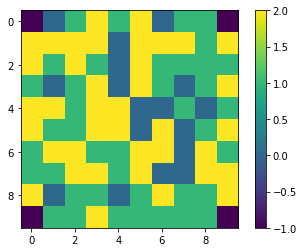

In [4]:
env.play_full_game(verbose=True)

In [8]:
for i in range(100):
  env.play_full_game(verbose=False)


In [4]:
env.learn(policy="parametrized", episodes=100)

[====================] Finished 100 episodes
